In [2]:
import sys
sys.path.append('models/')
sys.path.append('process_data/')
sys.path.append('eval/')

import libpysal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import scipy

# custom GCNN classes
from class_dataset import CTA_Data
from class_gcn_lstm import GCN_LSTM
from class_mve_loss import LN_MVELoss
from class_mve_loss import T_MVELoss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import util_gcnn
import util_eval
import util_plot
from setup import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 18})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
out_folder = "2102_rc"

period = "after"
dropout_rate_list=[0.25, 0.5]
n_hid_units_list=[50,100,150]
weight_decay_list = [0.001, 0.005, 0.01, 0.05]
max_lookback = 6
lookback = 4 
time_size = 4
predict_hzn = 2
n_time = 96 // time_size - 7

# type of adjcency matrix
# con-connectivity; net-network distance; euc-euclidean distance
adj_type = ["func","net"]

train_extent = "downtown"
difference = True

# 95% pct
z=1.96

In [3]:
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, period, predict_hzn, time_size, difference, max_lookback, lookback)

print("Data sources and shapes:")
for key,items in data.items():
    print(key, "\t", items[0].shape)

All Available Columns:
 ['STATION_ID', 'tot_population', 'pct25_34yrs', 'pct35_50yrs', 'pctover65yrs', 'pctwhite_alone', 'pct_nonwhite', 'pctblack_alone', 'pct_col_grad', 'pctPTcommute', '25_34yrs', '35_50yrs', 'over65yrs', 'white_alone', 'nonwhite', 'black_alone', 'col_grad', 'PTcommute', 'avg_tt_to_work', 'inc_per_capita', 'jobs', 'entertainment', 'restaurant', 'school', 'shop', 'all']


Columns included:
 ['STATION_ID', 'tot_population', 'pct_adults', 'pctover65yrs', 'pctPTcommute', 'avg_tt_to_work', 'inc_per_capita', 'entertainment', 'restaurant', 'school', 'shop']
Number of Stations Included: 134
Data sources and shapes:
x 	 (3143, 4, 134, 3)
y 	 (3143, 1, 134)
ref 	 (3143, 1, 134)
los 	 (3143, 134)
weather 	 (3143, 2)
qod 	 (3143,)
ts 	 (3143,)


In [4]:
adj_torch = torch.tensor([])
torch.cat((adj_torch, torch.tensor(adj['con']))).shape

torch.Size([134, 134])

In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
train_extent = 'downtown'
trainloader, trainloader_test, testloader, adj_torch, spatial_torch, y_train_eval, y_test_eval = \
                            util_gcnn.prepare_for_torch(device, train_extent, 
                            data,
                            adj, spatial, downtown_filter, adj_type)

In [6]:
(num_train, _, _, n_modes) = data['x'][0].shape
(num_test, _, _, _) = data['x'][1].shape
n_stations = adj_torch.shape[0]

In [7]:
y_train_eval = np.squeeze(y_train_eval)
y_test_eval = np.squeeze(y_test_eval)

In [ ]:
max_epochs = 301
start_hp = 0
end_hp = 3
same_hp = False
spatial_torch=None
if spatial_torch is None:
    ndemo = 0
else:
    ndemo = spatial.shape[1]
    
for ii in range(start_hp, end_hp):

    dropout = np.random.choice(dropout_rate_list)
    n_hid_units = np.random.choice(n_hid_units_list)
    weight_decay = np.random.choice(weight_decay_list)
    
    print('Model ', ii)
    print('Lookback: ', lookback)
    print('Dropout:', dropout)
    print('Hidden Units:', n_hid_units)
    print('Weight Decay:', weight_decay)
    
    net = GCN_LSTM(meanonly=True, nadj = len(adj_type), nmode=n_modes, nstation=n_stations, ntime=n_time, 
                   ndemo=ndemo, 
              nhid_g=n_hid_units, nhid_l=n_hid_units, nlstm=1, 
              nhid_fc=n_hid_units, dropout=dropout)
    net.to(device)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=weight_decay)
    
    for epoch in range(max_epochs):
        
        running_loss = 0.0

        for i, batch_data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            batch_x, batch_y, batch_history, batch_weather, batch_los, batch_qod = batch_data
            batch_size=len(batch_x)
            
            batch_x = batch_x.float()
            batch_y = batch_y.float()
            batch_history = batch_history.float()
            batch_qod = batch_qod.view(-1,1)
            batch_qod_onehot = torch.FloatTensor(batch_size, n_time)
            batch_qod_onehot.zero_()
            batch_qod_onehot.scatter_(1, batch_qod-6, 1)
            batch_x, batch_y, batch_history, batch_weather, batch_los, batch_qod_onehot = \
                batch_x.to(device), batch_y.to(device), batch_history.to(device), \
                batch_weather.to(device), batch_los.to(device), batch_qod_onehot.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward 
            outputs = net(batch_x, None, adj_torch, batch_history, spatial_torch, 
                          batch_weather, batch_los, batch_qod_onehot, 1)
            
            # loss
            loss = criterion(torch.squeeze(outputs), torch.squeeze(batch_y))
            
            # backward
            loss.backward()

            # optimize
            optimizer.step()

            running_loss += loss.item()
            

        if epoch % 50 == 0:
            print('[%d] loss: %.3f' %
              (epoch + 1, running_loss/num_train), end = '\t')
        
    print('Finished Training ', str(ii))

    net.eval()

    test_out_mean, _ = util_gcnn.testset_output_gcn(testloader, True, net, criterion, adj_torch, spatial_torch, device, n_time)
    train_out_mean, _ = util_gcnn.testset_output_gcn(trainloader_test, True, net, criterion, adj_torch, spatial_torch, device, n_time)

    mae, mse, _, _, _ = util_eval.eval_mean(test_out_mean, y_test_eval, 'Test')
    tr_mae, tr_mse, _, _, pct_nonzeros = util_eval.eval_mean(train_out_mean, y_train_eval, 'Train')

    with open(project_dir+"results/rail_catchment_mse_results.csv","a") as f:
        f.write("%s,%s,%s,%s,%s,%d,%d,%d,%d,%.2f,%d,%.2E,%.2f,%.2f,%.2f,%.2f\n" % 
                ('GCN', period, train_extent, train_extent, '_'.join(adj_type), ii, 
                predict_hzn, time_size, lookback, 
                dropout, n_hid_units, weight_decay, 
                tr_mae, tr_mse, 
                mae, mse))

Model  0
Lookback:  4
Dropout: 0.5
Hidden Units: 100
Weight Decay: 0.01
[1] loss: 19.707	[51] loss: 7.960	

In [9]:
out = util_gcnn.testset_output_gcn(testloader, True, net, criterion, adj_torch, spatial_torch, device, n_time, 
                               return_components=True)

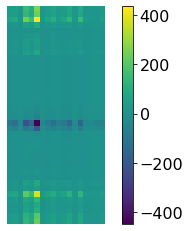

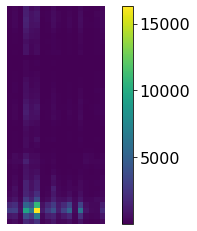

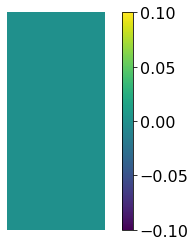

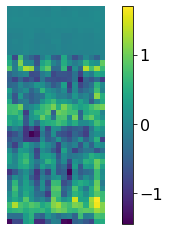

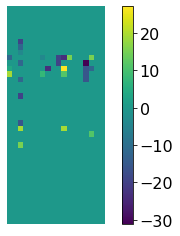

In [10]:
for i in range(len(out)):
    plt.figure()
    plt.imshow(out[i].cpu().detach().numpy()[:40,:])#/test_out_mean[:20,:])
    plt.colorbar()
    plt.axis('off')
    #print(out[i].cpu().detach().numpy()[:20,2])
    #print(test_out_mean[:20,2])
    #break

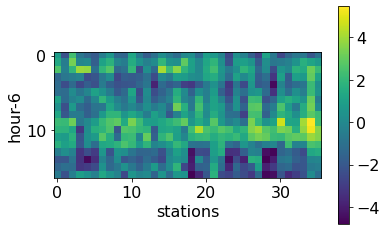

In [11]:
for p in net.named_parameters():
    if p[0] == 'weather_weights_mean':
        plt.imshow(p[1].cpu().detach().numpy())
#plt.axis('off')
plt.xlabel("stations")
plt.ylabel("hour-6")
plt.colorbar();

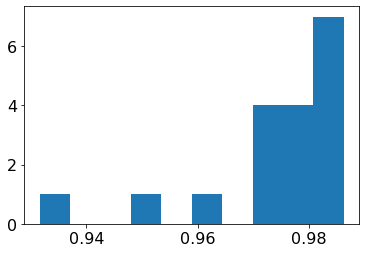

In [12]:
for p in net.named_parameters():
    if p[0] == 'history_weights_mean':
        plt.hist(p[1].cpu().detach().numpy())


In [13]:
for p in net.named_parameters():
    if p[0] == 'los_weights_mean':
        print(p[1])

Parameter containing:
tensor([3.8794], device='cuda:1', requires_grad=True)


In [15]:
for p in net.named_parameters():
    print(p[0])

history_weights_mean
weather_weights_mean
los_weights_mean
batchnorm.weight
batchnorm.bias
gc.0.weight
gc.0.bias
gc.1.weight
gc.1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
lstmcell.weight_ih
lstmcell.weight_hh
lstmcell.bias_ih
lstmcell.bias_hh
lstm_out.weight
lstm_out.bias
fc3.weight
fc3.bias
final.weight
final.bias


Plotting station with max flow:  86


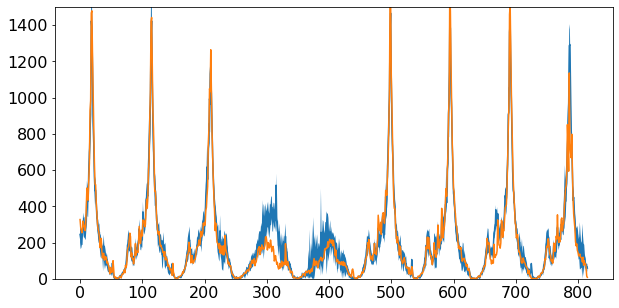

In [53]:
# station with maximum demand to plot time series
plot_station = np.argmax(np.mean(y_test, axis=0), axis=None)

print("Plotting station with max flow: ", plot_station)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test_out_mean[:, plot_station])
ax.plot(y_test[:, plot_station]);

Plotting another station:  100


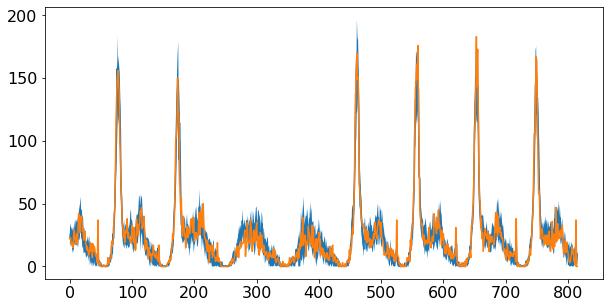

In [55]:
plot_station = 100
print("Plotting another station: ", plot_station)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test_out_mean[:, plot_station])
ax.plot(y_test[:, plot_station]);

Plotting a neighbouring cell with less flow:  1


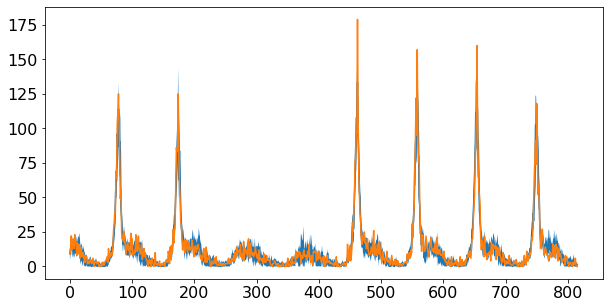

In [56]:
plot_station = 1
print("Plotting a neighbouring cell with less flow: ", plot_station)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test_out_mean[:, plot_station])
ax.plot(y_test[:, plot_station]);

Plotting a neighbouring cell with very small flow:  10


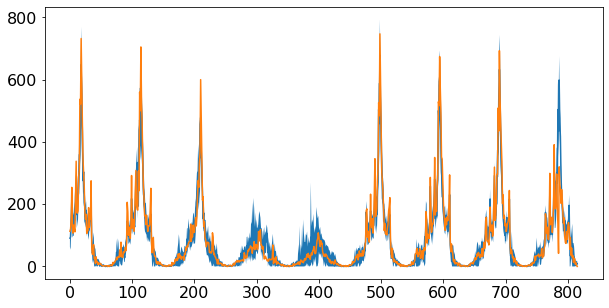

In [57]:
plot_station = 10
print("Plotting a neighbouring cell with very small flow: ", plot_station)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test_out_mean[:, plot_station])
ax.plot(y_test[:, plot_station]);

## Fit

In [19]:
# mean absolute error
print('Modelled')
print('(Test) Mean Absolute Error: %.3f' % np.mean(np.abs(test_out_mean - y_test_eval)))
# mean squared error
print('(Test) Mean Squared Error: %.3f' % np.mean(np.power(test_out_mean - y_test_eval, 2)))

# number from last week
print('Number from last week')
# mean absolute error
print('(Test) Mean Absolute Error: %.3f' % np.mean(np.abs(test_out_mean - y_test_eval)))
# mean squared error
print('(Test) Mean Squared Error: %.3f' % np.mean(np.power(test_out_mean - y_test_eval, 2)))

Modelled
(Test) Mean Absolute Error: 69.607
(Test) Mean Squared Error: 47975.773
Number from last week
(Test) Mean Absolute Error: 69.607
(Test) Mean Squared Error: 47975.773


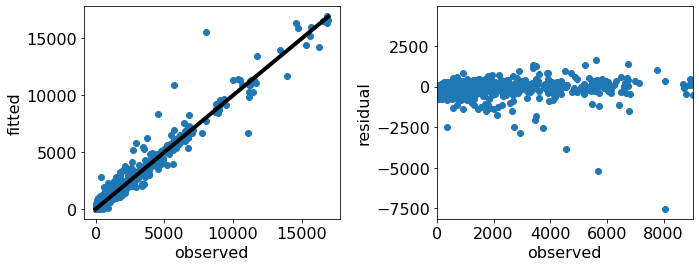

In [22]:
util_plot.plot_fit_res(y_test_eval.flatten(), test_out_mean.flatten())

In [60]:
spatial_mean=np.nanmean(y_test, axis=0)
modelled_mean=np.nanmean(test_out_mean, axis=0)
res = np.nanmean(test_res, axis=0)

df = pd.DataFrame(np.array([station_ids, spatial_mean, modelled_mean, res]).T, 
                  columns=['station_id','obs_mean','model_mean','residual'])

In [61]:
stations = gpd.read_file('../data/data_raw/CTA_Rail/CTA_RailStations.shp')
stations = stations.to_crs(CRS("epsg:4326"))

In [62]:
def plot_output_spatial(stations, df, merge_cols_left, merge_cols_right, value_col, title, cmap):

    temp = pd.merge(stations, df, left_on=merge_cols_left, right_on=merge_cols_right)
    scheme = mc.Quantiles(temp[value_col], k=5)
    # get all upper bounds
    upper_bounds = scheme.bins
    # get and format bounds
    bounds = []
    for index, upper_bound in enumerate(upper_bounds):
        if index == 0:
            lower_bound = df[value_col].min()
        else:
            lower_bound = upper_bounds[index-1]

        # format the numerical legend here
        bound = f'{lower_bound:.0f} - {upper_bound:.0f}'
        bounds.append(bound)

    chicago = (stations.geometry.x.min(), stations.geometry.y.min(),
               stations.geometry.x.max(), stations.geometry.y.max())
    downtown = (-87.645168, 41.872034, -87.623921, 41.889749)
    contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
    a = gplt.pointplot(temp, projection=gcrs.WebMercator(), cmap=cmap,
                  hue=value_col, scale=value_col, limits=(5,30), scheme=scheme, extent=chicago, legend=False)
    gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), ax=a, extent=chicago)
    # this patch won't show up with webmap, need to investigate further
    #gplt.gca().add_patch(Rectangle((-87.645168, 41.872034),0.021247,0.017715,linewidth=5,edgecolor='r',facecolor='r'))
    # this does not work either, cannot overlay polygon on webmap, seems that only pointplot works.
    #a = gplt.polyplot(poly, projection=gcrs.WebMercator(), extent=chicago) 
    plt.title(title)
 
    plt.savefig("../figures/20201201/"+value_col+".png")
    a = gplt.pointplot(temp, projection=gcrs.WebMercator(), hue=value_col, scale=value_col, limits=(5,30),
                       scheme=scheme, legend=True, legend_var='hue',cmap=cmap,
                  legend_kwargs={'bbox_to_anchor': (1, 0.5), 'frameon': True})
    gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), ax=a, extent=downtown)
    plt.title('Downtown Zoom')
   # get all the legend labels
    legend_labels = a.get_legend().get_texts()

    # replace the legend labels
    for bound, legend_label in zip(bounds, legend_labels):
        legend_label.set_text(bound)
 
    plt.savefig("../figures/20201201/"+value_col+"_downtown.png")

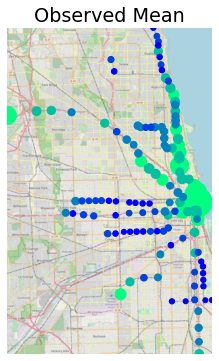

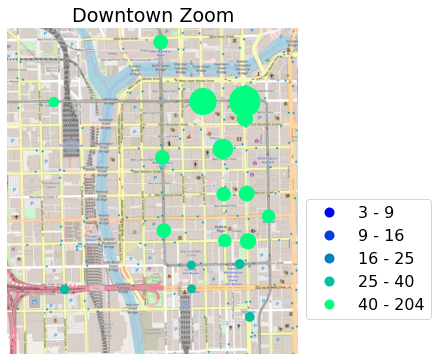

In [63]:
plot_output_spatial(stations, df, merge_cols_left='STATION_ID', merge_cols_right='station_id', 
                              value_col='obs_mean', title='Observed Mean', cmap='winter')


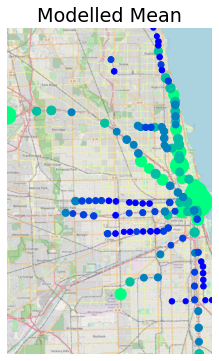

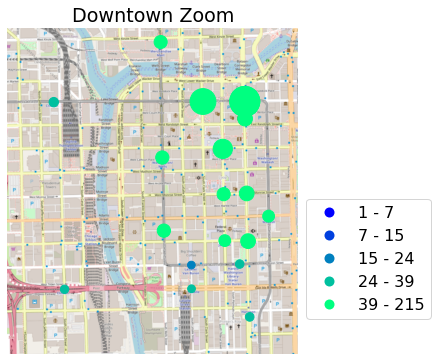

In [64]:
plot_output_spatial(stations, df, merge_cols_left='STATION_ID', merge_cols_right='station_id', 
                              value_col='model_mean', title='Modelled Mean', cmap='winter')


## Temporal Distribution of Residuals

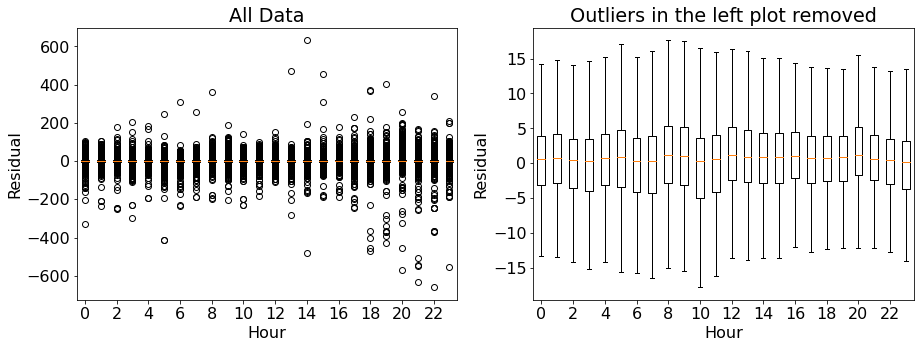

In [66]:
util_plot.plot_res_temp_ind(y_test, test_res, ts_test, n_stations)

## Temporal Distribution of Residuals (spatially aggregated)

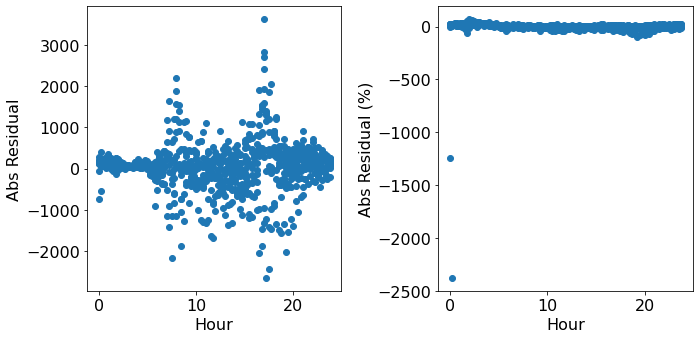

In [67]:
util_plot.plot_res_temp_agg(y_test, test_res, ts_test, include_zeros=True);

## Spatial Distribution of Residuals

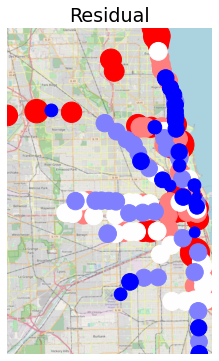

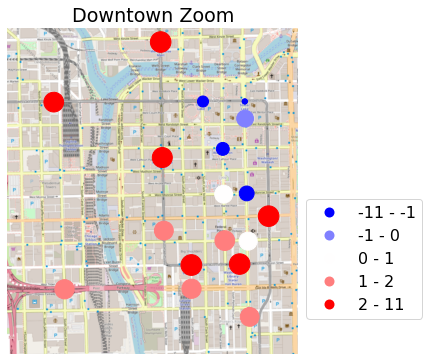

In [68]:
plot_output_spatial(stations, df, merge_cols_left='STATION_ID', merge_cols_right='station_id', 
                              value_col='residual', title='Residual', cmap='bwr')

## Residual Structure of Nonzero Entries

In [69]:
zero_mask = y_test!=0
zero_mask_flat = zero_mask.flatten()
num_nonzero = np.sum(y_test!=0)

In [70]:
# mean absolute error
print('(Test) Mean Absolute Error: %.3f' % (np.sum(np.abs(test_out_mean - y_test)[zero_mask])/num_nonzero))
# mean squared error
print('(Test) Mean Squared Error: %.3f' % (np.sum(np.power(test_out_mean - y_test, 2)[zero_mask])/num_nonzero))

(Test) Mean Absolute Error: 7.640
(Test) Mean Squared Error: 294.590


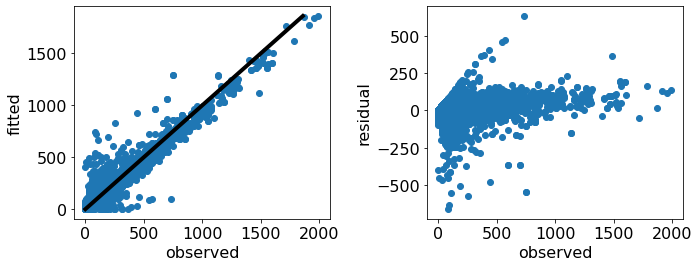

In [71]:
util_plot.plot_fit_res(y_test.flatten()[zero_mask_flat], 
                       test_out_mean.flatten()[zero_mask_flat], 
                       test_res.flatten()[zero_mask_flat])

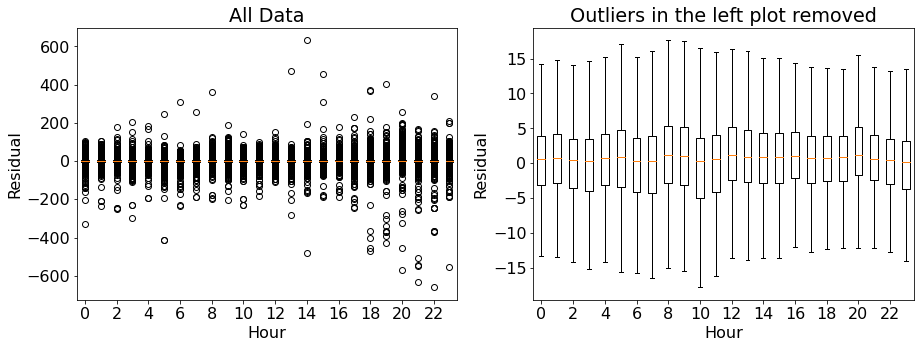

In [72]:
util_plot.plot_res_temp_ind(y_test, test_res, ts_test, n_stations, include_zeros=False)

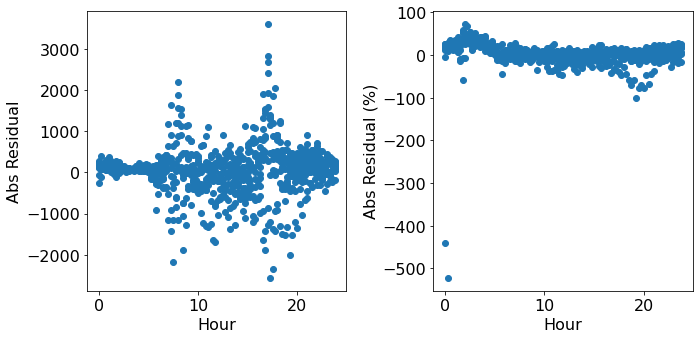

In [73]:
util_plot.plot_res_temp_agg(y_test, test_res, ts_test, include_zeros=False);

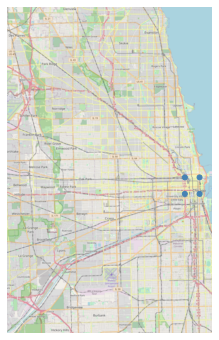

In [181]:
start_lon = -87.645168, -87.623921, -87.623921, -87.645168
start_lat = 41.872034, 41.872034, 41.889749, 41.889749
end_lon = -87.623921, -87.623921, -87.645168, -87.645168
end_lat = 41.872034, 41.889749, 41.889749, 41.872034
start_points = [Point(xy) for xy in zip(start_lon, start_lat)]
end_points = [Point(xy) for xy in zip(end_lon, end_lat)]
lines = [LineString(xy) for xy in zip(start_points, end_points)]
poly = Polygon(start_points)
poly = gpd.GeoDataFrame([0], crs=CRS("epsg:4326"), geometry=[poly])
chicago = (stations.geometry.x.min(), stations.geometry.y.min(),
           stations.geometry.x.max(), stations.geometry.y.max())
downtown = (-87.645168, 41.872034, -87.623921, 41.889749)
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

pts = gpd.GeoDataFrame(np.array([1,2,3,4]).T, crs=CRS("epsg:4326"), geometry=start_points)
#a = gplt.polyplot(poly, projection=gcrs.WebMercator(), linewidth=4)
a = gplt.pointplot(pts, projection=gcrs.WebMercator())
gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), ax=a, extent=chicago)
